In [1]:
import numpy as np
import tensorflow as tf

print(tf.__version__)

#config = tf.ConfigProto(intra_op_parallelism_threads=3, inter_op_parallelism_threads=3, \
#                        allow_soft_placement=True, device_count = {'CPU': 1})
#session = tf.Session(config=config)
session = tf.InteractiveSession()


1.2.0-rc2


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

trainX = mnist.train.images.reshape((-1,28,28)) # convert from (batch, 784) to (batch, 28, 28) to make ordinary images
trainY = mnist.train.labels

testX = mnist.test.images.reshape((-1,28,28))
testY = mnist.test.labels

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)


Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
(55000, 28, 28)
(55000, 10)
(10000, 28, 28)
(10000, 10)


In [3]:
valX = trainX[:10000,]
trainX = trainX[10000:,]
valY = trainY[:10000,]
trainY = trainY[10000:,]

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_img(sample):
    pixels = np.array(sample, dtype = 'float32')
    #
    plt.imshow(pixels)
    plt.show()
    

TypeError: Invalid dimensions for image data

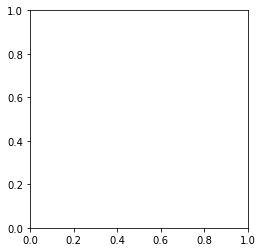

In [27]:
for i in range(20):
    show_img(trainX[i*20, :])
    print (trainY[i*20])

In [6]:
example_num, input_n, input_m = trainX.shape
output_num = len(trainY[0,:])
print(example_num, input_n, input_m, output_num)

45000 28 28 10


In [7]:
trainX.shape, valX.shape, testX.shape

((45000, 28, 28), (10000, 28, 28), (10000, 28, 28))

In [8]:
trainX = np.reshape(trainX, (45000, 28, 28, 1))
valX = np.reshape(valX, (10000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

In [9]:
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

1.2.0-rc2
2.0.4


Using TensorFlow backend.


In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

def reset_tf_session():
    K.clear_session()
    tf.reset_default_graph()
    s = K.get_session()
    return s

In [11]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), strides = (1, 1), padding="same", name = 'conv1', input_shape=(28, 28, 1)))   
    model.add(LeakyReLU(0.1))
    
    model.add(Conv2D(32, (3, 3), strides = (1, 1), padding="same", name = 'conv2'))   
    model.add(LeakyReLU(0.1))
    
    model.add(MaxPooling2D((2, 2), name='max_pool_1'))
    
    model.add(Dropout(0.25, noise_shape=None, seed=0))
    
    model.add(Conv2D(32, (3, 3), strides = (1, 1), padding="same", name = 'conv3')) 
    model.add(LeakyReLU(0.1))
    
    model.add(Conv2D(64, (3, 3), strides = (1, 1), padding="same", name = 'conv4'))  
    model.add(LeakyReLU(0.1))
    
    model.add(MaxPooling2D((2, 2), name='max_pool_2'))
    
    # Dropout
    model.add(Dropout(0.25, noise_shape=None, seed=0))
    model.add(Flatten())    
    
    # FC
    model.add(Dense(256, name='fc1'))
    model.add(Dropout(0.5, noise_shape=None, seed=0))
    
    model.add(Dense(10))  # the last layer with neuron for each class
    model.add(Activation("softmax"))  # output probabilities
    return model

In [12]:
# K.clear_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 16)        160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 32)        4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 14, 14, 32)        9248      
__________

In [13]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 50
EPOCHS = 10

# K.clear_session()  # clear default graph
# # don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
# model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

In [14]:
last_finished_epoch = None
model.fit(
    trainX, trainY,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
        callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory()], 
    validation_data=(valX, valY),
    shuffle=True,
    verbose=1
)

Train on 45000 samples, validate on 10000 samples
Learning rate: 0.005
Epoch 1/10
45000/45000 [==============================] - 153s - loss: 0.1526 - acc: 0.9530 - val_loss: 0.0730 - val_acc: 0.9780
Learning rate: 0.0045
Epoch 2/10
45000/45000 [==============================] - 172s - loss: 0.0623 - acc: 0.9810 - val_loss: 0.0527 - val_acc: 0.9842
Learning rate: 0.00405
Epoch 3/10
45000/45000 [==============================] - 147s - loss: 0.0468 - acc: 0.9854 - val_loss: 0.0337 - val_acc: 0.9898
Learning rate: 0.003645
Epoch 4/10
45000/45000 [==============================] - 170s - loss: 0.0373 - acc: 0.9882 - val_loss: 0.0371 - val_acc: 0.9880
Learning rate: 0.0032805
Epoch 5/10
45000/45000 [==============================] - 167s - loss: 0.0304 - acc: 0.9903 - val_loss: 0.0341 - val_acc: 0.9914
Learning rate: 0.00295245
Epoch 6/10
45000/45000 [==============================] - 146s - loss: 0.0270 - acc: 0.9912 - val_loss: 0.0311 - val_acc: 0.9901
Learning rate: 0.00265721
Epoch 7/1

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [16]:
scores = model.evaluate(testX, testY, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 12s    
Test loss: 0.0185263405963
Test accuracy: 0.9951


In [21]:
sas = model.predict(testX)
sas = sas.argmax(axis=-1)
a = []
for i in range(len(testY)):
    if testY[i][sas[i]] != 1:
        a.append(i)

In [35]:
testX_pic = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

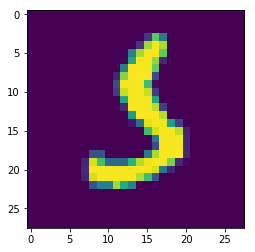

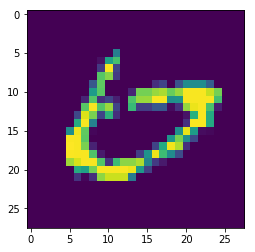

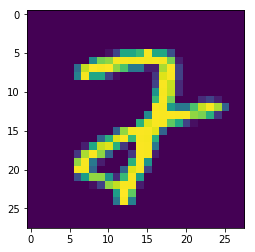

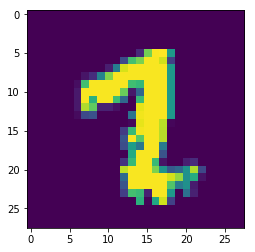

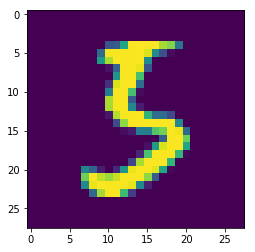

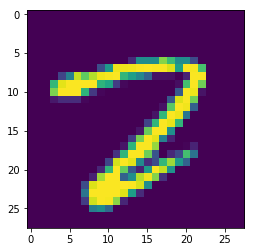

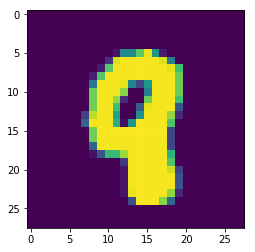

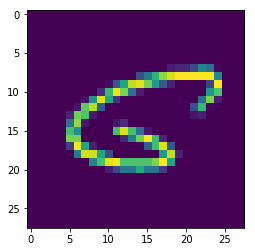

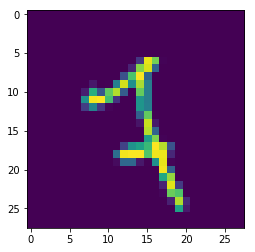

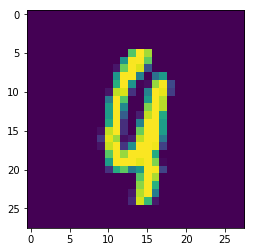

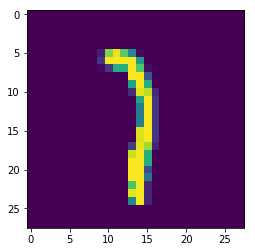

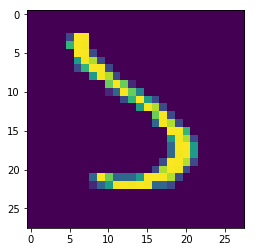

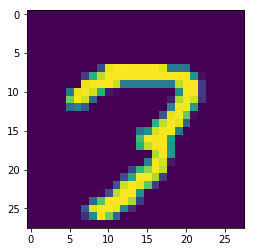

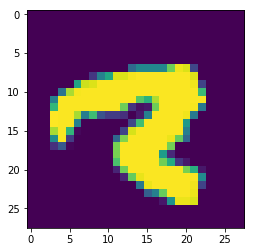

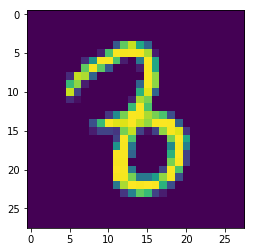

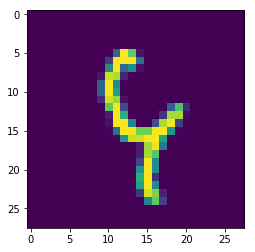

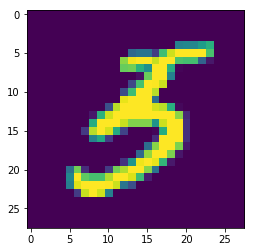

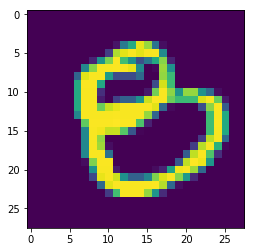

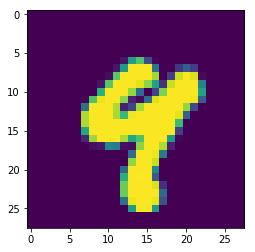

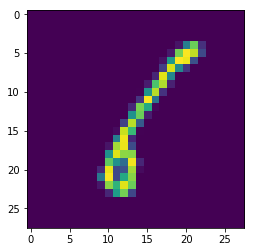

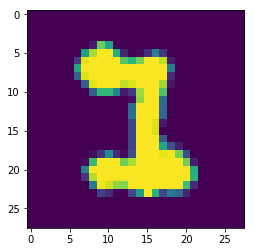

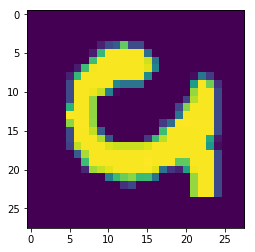

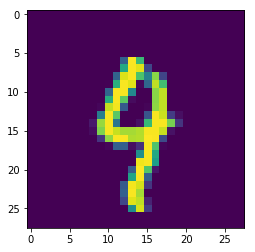

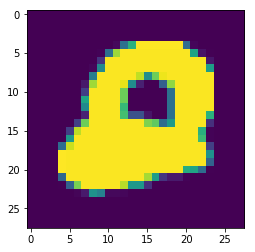

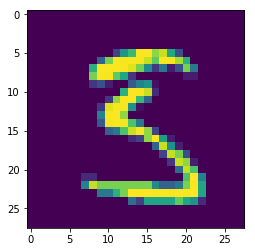

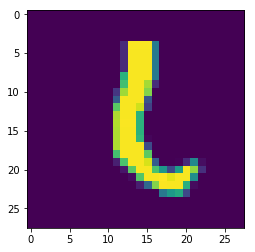

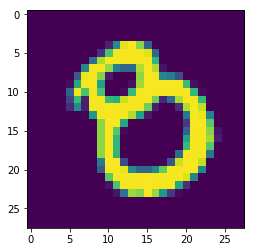

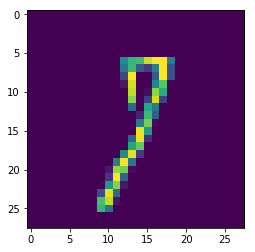

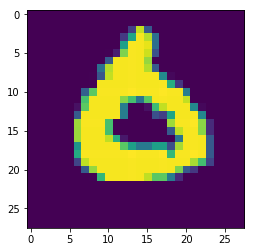

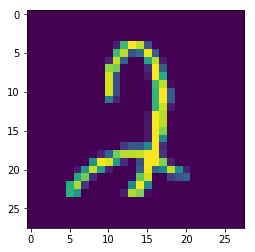

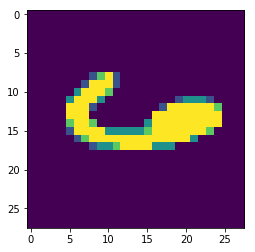

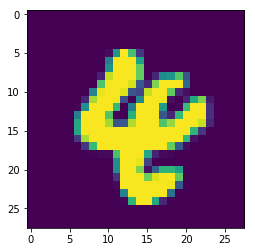

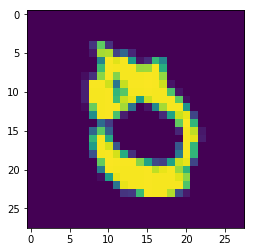

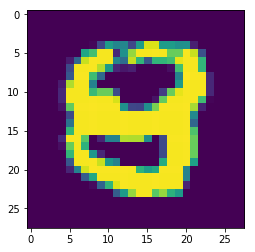

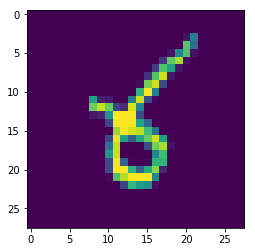

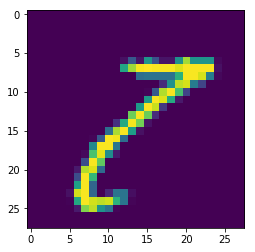

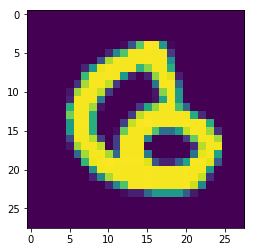

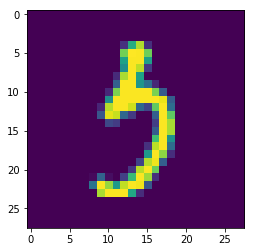

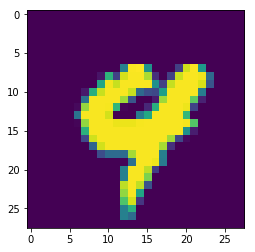

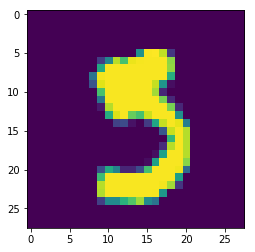

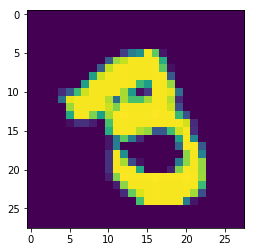

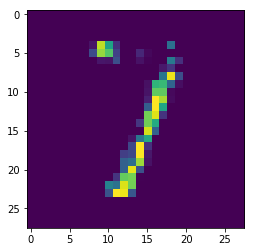

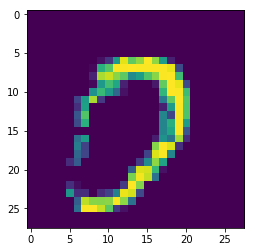

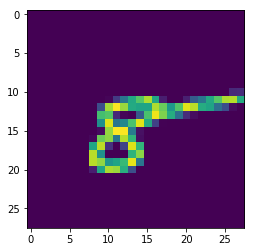

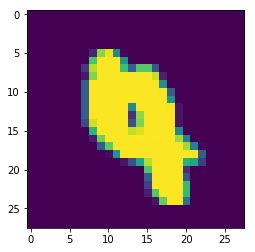

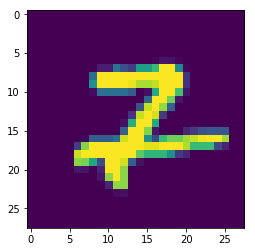

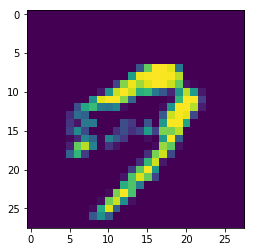

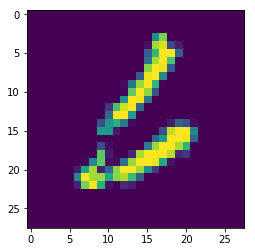

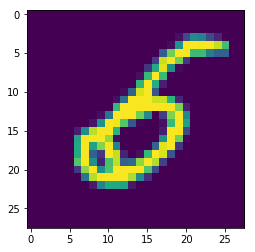

In [36]:
for i in range(len(a)):
    show_img(testX_pic[a[i]])

Keras was not restricted, so i used this. From model summary it is easy to see that model has 838186 parameters. Most of wrongly classified pictures are kind of strange numbers - some of them i cant classify too.